In [3]:
import importlib
import pathlib as pl
import sqlite3

from tqdm import tqdm

import grid_load.processing as glp

importlib.reload(glp)

conn = sqlite3.connect("local.db")

# files = list(pl.Path("../data").glob("*.csv"))
# for file in tqdm(files, total=len(files)):
#     df = glp.extract_data(file)
#     df = glp.transform_data(df)
#     if "Trafostation" in file.stem:
#         df.to_sql("grid_consumption", conn, if_exists="append", index=False)
#     elif "Wohnung" in file.stem:
#         user_id = int(file.stem.split("_")[0])
#         df["user_id"] = user_id
#         df.to_sql("user_consumption", conn, if_exists="append", index=False)

# conn.close()

In [13]:
import pandas as pd

sql = "Select * from grid_consumption order by ts desc"
df_lite = pd.read_sql(sql, conn)

In [14]:
df_lite[df_lite["ts"] == 1725968700]

,Datum,Zeitstempel,ObisCode,Wert,Status,date_fmt,moving_avg,quantile,threshold,high_usage,diff_percentage,ts
83,10.09.2024 13:45:00 +02:00,1725968700,01.05.2000,126.0,Normal,2024-09-10 11:45:00+00:00,75.363393,97.95,97.95,1,8.032695,1.725969e+09


Locator attempting to generate 1263 ticks ([-14.333333333333334, ..., 301.1666666666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1263 ticks ([-14.333333333333334, ..., 301.1666666666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1263 ticks ([-14.333333333333334, ..., 301.1666666666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1263 ticks ([-14.333333333333334, ..., 301.1666666666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1263 ticks ([-14.333333333333334, ..., 301.1666666666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1263 ticks ([-14.333333333333334, ..., 301.1666666666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1263 ticks ([-14.333333333333334, ..., 301.1666666666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1263 ticks ([-14.333333333333334, ..., 301.1666666666667]),

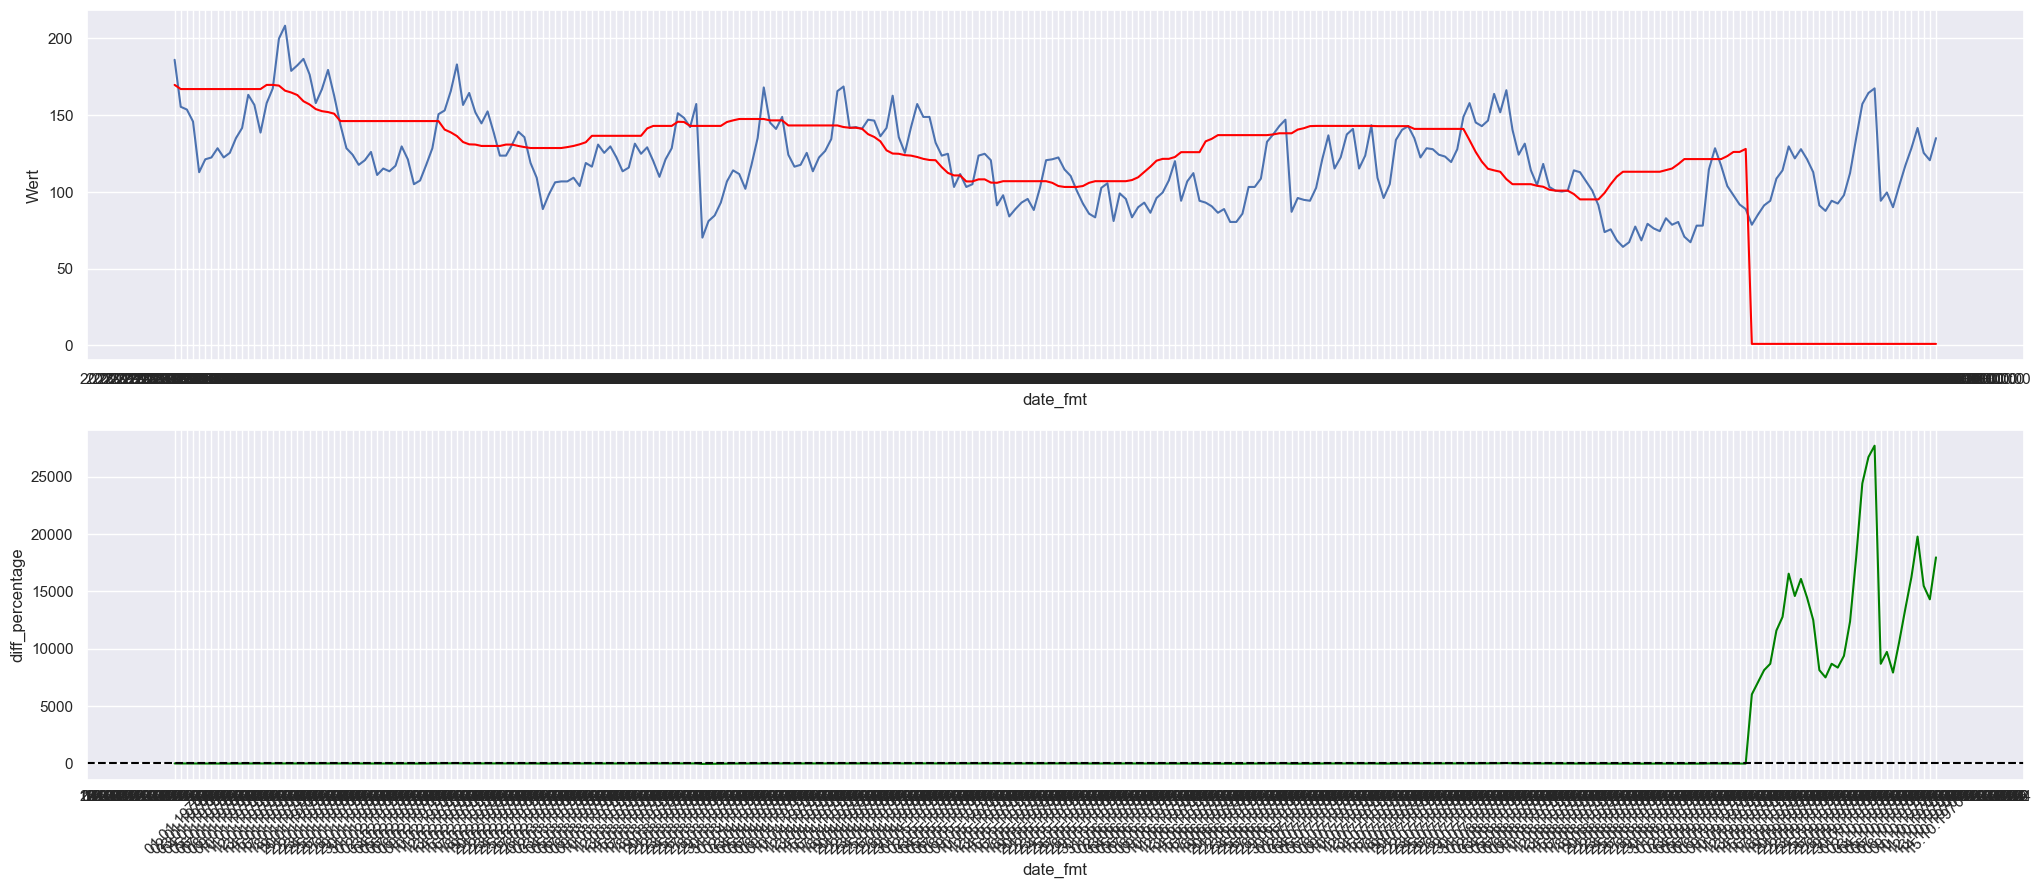

In [5]:
to_display = df_lite.tail(4 * 24 * 3)

glp.plot(to_display)